### Shelf waves

Which waves am I looking for?

In [2]:
import cmocean as cmo
import gsw
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import scipy as sc
import scipy.io as sio
from scipy import interpolate

%matplotlib inline

In [3]:
bat_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'
bathy = Dataset(bat_file)

depth = bathy['Depth'][:]
X = bathy['X'][:]
Y = bathy['Y'][:]
Z = bathy['Z'][:]
hfacC = bathy['HFacC']
hfacW = bathy['HFacW']
hfacS = bathy['HFacS']

Yv = bathy['Yp1'][:]
Xu = bathy['Xp1'][:]
Zw = bathy['Zl'][:]

maskC = np.ma.getmask(np.ma.masked_equal(hfacC, 0))
maskW = np.ma.getmask(np.ma.masked_equal(hfacW, 0))
maskS = np.ma.getmask(np.ma.masked_equal(hfacS, 0))

In [6]:
batNoC_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'
bathyNoC = Dataset(batNoC_file)

depthNoC = bathyNoC['Depth'][:]
XNoC = bathyNoC['X'][:]
YNoC = bathyNoC['Y'][:]
ZNoC = bathyNoC['Z'][:]
hfacCNoC = bathyNoC['HFacC']
hfacWNoC = bathyNoC['HFacW']
hfacSNoC = bathyNoC['HFacS']

YvNoC = bathyNoC['Yp1'][:]
XuNoC = bathyNoC['Xp1'][:]
ZwNoC = bathyNoC['Zl'][:]

maskCNoC = np.ma.getmask(np.ma.masked_equal(hfacCNoC, 0))
maskWNoC = np.ma.getmask(np.ma.masked_equal(hfacWNoC, 0))
maskSNoC = np.ma.getmask(np.ma.masked_equal(hfacSNoC, 0))

In [4]:
def plot_CS_wave(Vmean, Umean, Wmean, SSHmean, time, xind=240, umean = 0.3):    
    fig, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(18, 10))

    for ax in (ax1,ax2,ax3):
        ax.set_facecolor('#8b7765')

    ax1.contourf(Yv/1000, Z, Vmean[:, :, xind],15, vmin=-0.2, vmax=0.2, cmap=cmo.cm.balance)
    ax2.contourf(Y/1000, Z, Umean[:, :, xind]-umean,15, vmin=-0.5, vmax=0.5, cmap=cmo.cm.balance)
    ax3.contourf(Y/1000, Zw, Wmean[:, :, xind],15, vmin=-0.003, vmax=0.003, cmap=cmo.cm.balance)

    ax1.set_ylabel('Depth / m')
    ax1.set_xlabel('Cross-shelf distance/ km')
    ax1.set_title('V')
    ax2.set_ylabel('Depth / m')
    ax2.set_xlabel('Cross-shelf distance / km')
    ax2.set_title('U-0.3 m/s')

    for ax in (ax4,ax5,ax6):
        ax.axhline(0, color='gold')

    ax4.plot(Yv/1000, Vmean[0, :, xind], c='0.3')
    ax5.plot(Y/1000, Umean[0, :, xind], c='0.3')
    ax6.plot(Y/1000, SSHmean[:, xind], c='0.3')

    ax4.set_ylabel('m/s')
    ax4.set_xlabel('Cross-shelf distance/ km')
    ax4.set_title('V surface')
    ax5.set_ylabel('m/s')
    ax5.set_xlabel('Cross-shelf distance / km')
    ax5.set_title('U-0.3 m/s surface')
    ax6.set_xlabel('Cross-shelf distance / km')
    ax6.set_title('SSH')
    ax6.set_ylabel('m')
    ax1.text(10,-100,'day %1.1f' %(time/2.))


mean fields during advective phase


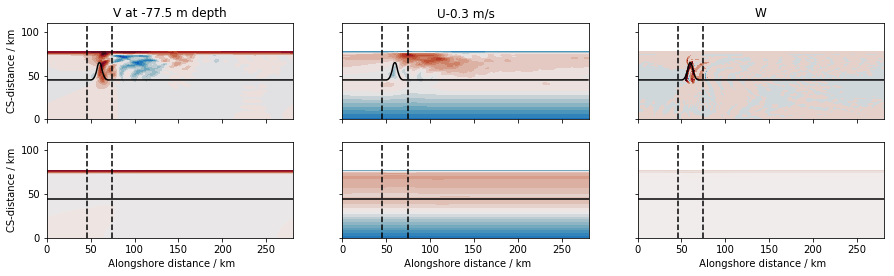

In [21]:
st_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc'
state = Dataset(st_file)
stNoC_file = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/stateGlob.nc'
stateNoC = Dataset(stNoC_file)

fig, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15,4), sharex=True, sharey=True)

start = 8
end = 19
zind = 15

V_h = np.ma.masked_array(np.mean(state['V'][start:end,zind,:,:], axis=0), mask = maskS[zind,:,:])
U_h = np.ma.masked_array(np.mean(state['U'][start:end,zind,:,:]-0.3, axis=0), mask = maskW[zind,:,:])
W_h = np.ma.masked_array(np.mean(state['W'][start:end,zind,:,:], axis=0), mask = maskC[zind,:,:])

ax1.contourf(X/1000,Yv/1000,V_h,20, cmap=cmo.cm.balance, vmin=-0.2, vmax=0.2)
ax2.contourf(Xu/1000,Y/1000,U_h,20, cmap=cmo.cm.balance, vmin=-0.5, vmax=0.5)
ax3.contourf(X/1000,Y/1000,W_h,20, cmap=cmo.cm.balance, vmin=-0.005, vmax=0.005)

V_hNoC = np.ma.masked_array(np.mean(stateNoC['V'][start:end,zind,:,:], axis=0), mask = maskSNoC[zind,:,:])
U_hNoC = np.ma.masked_array(np.mean(stateNoC['U'][start:end,zind,:,:]-0.3, axis=0), mask = maskWNoC[zind,:,:])
W_hNoC = np.ma.masked_array(np.mean(stateNoC['W'][start:end,zind,:,:], axis=0), mask = maskCNoC[zind,:,:])

ax4.contourf(XNoC/1000,YvNoC/1000,V_hNoC,20, cmap=cmo.cm.balance, vmin=-0.2, vmax=0.2)
ax5.contourf(XuNoC/1000,YNoC/1000,U_hNoC,20, cmap=cmo.cm.balance, vmin=-0.5, vmax=0.5)
ax6.contourf(XNoC/1000,YNoC/1000,W_hNoC,20, cmap=cmo.cm.balance, vmin=-0.005, vmax=0.005)

for ax, bat in zip([ax1,ax2,ax3,ax4,ax5,ax6],['can','can','can','NoC','NoC','NoC']):
    ax.set_aspect(1)
    ax.axvline(X[260]/1000, color='k', linestyle='--')
    ax.axvline(X[100]/1000, color='k', linestyle='--')
    if bat == 'NoC':
        ax.contour(XNoC/1000,YNoC/1000,depthNoC,levels=[150], colors=['k'])
    else:
        ax.contour(X/1000,Y/1000,depth,levels=[150], colors=['k'])
ax1.set_title('V at %1.1f m depth' %Z[zind])
ax2.set_title('U-0.3 m/s')
ax3.set_title('W')

for ax in [ax1,ax4]:
    ax.set_ylabel('CS-distance / km')    

for ax in [ax4,ax5,ax6]:
    ax.set_xlabel(' Alongshore distance / km')    
ax1.set_xlim(X[0]/1000,X[-1]/1000)
ax1.set_ylim(Y[0]/1000,Y[-1]/1000)
print('mean fields during advective phase')

Cross-sections at x=74.45 km (downstream side)


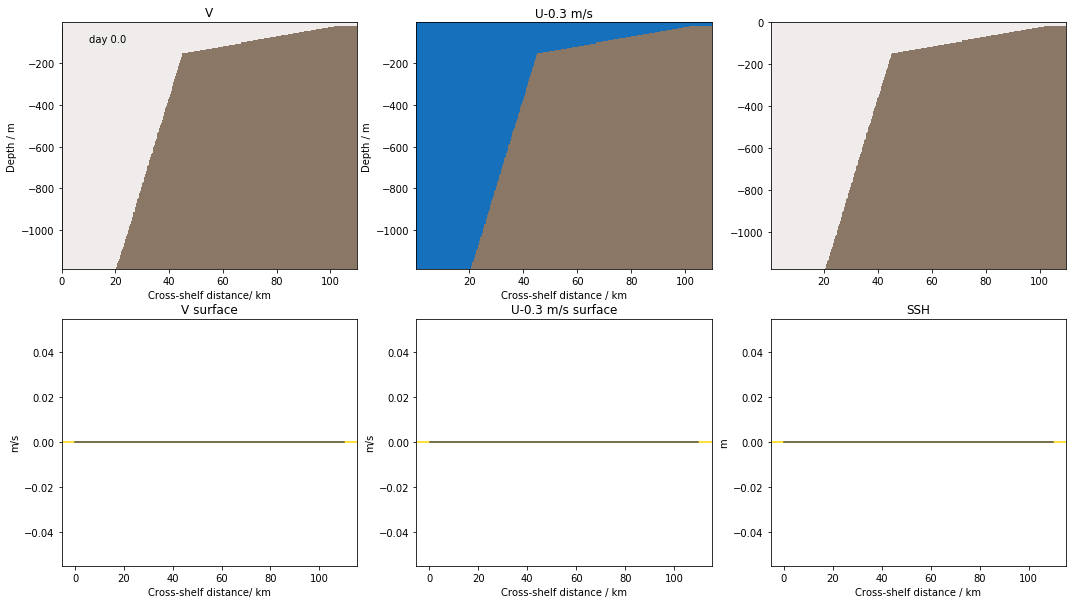

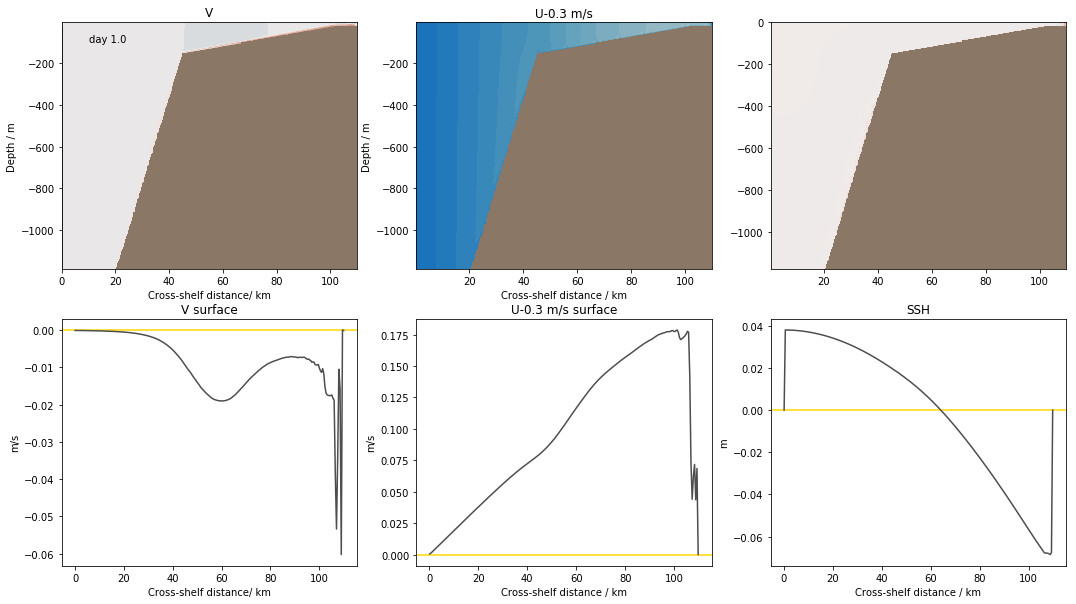

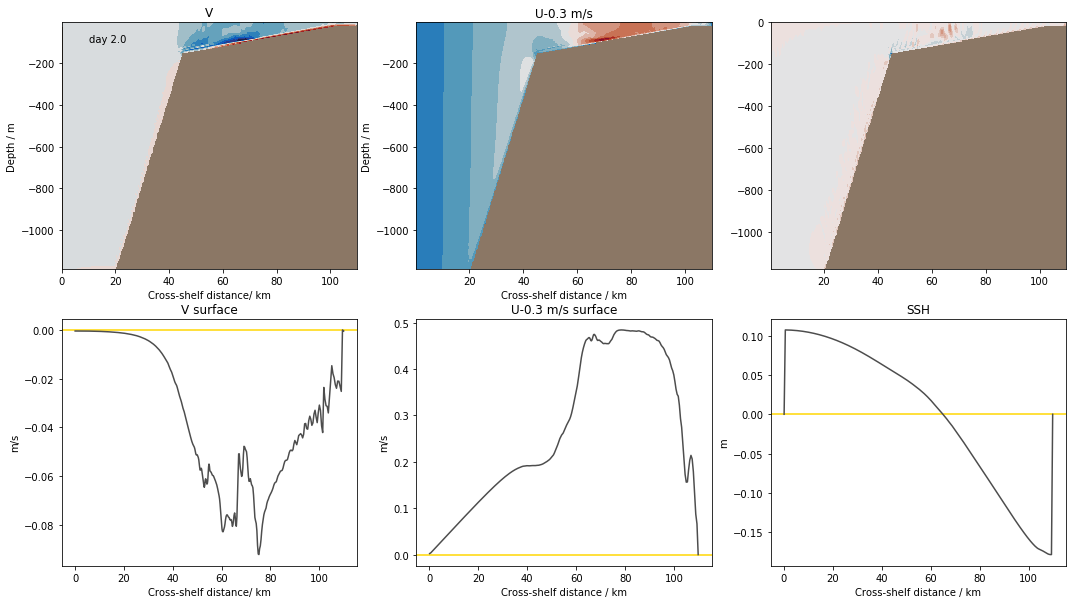

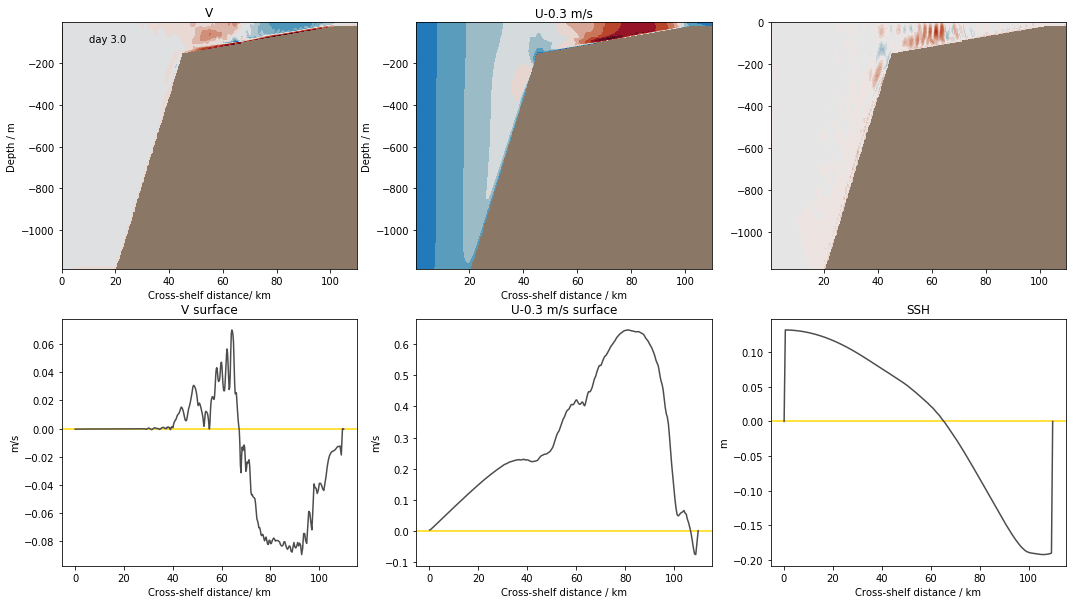

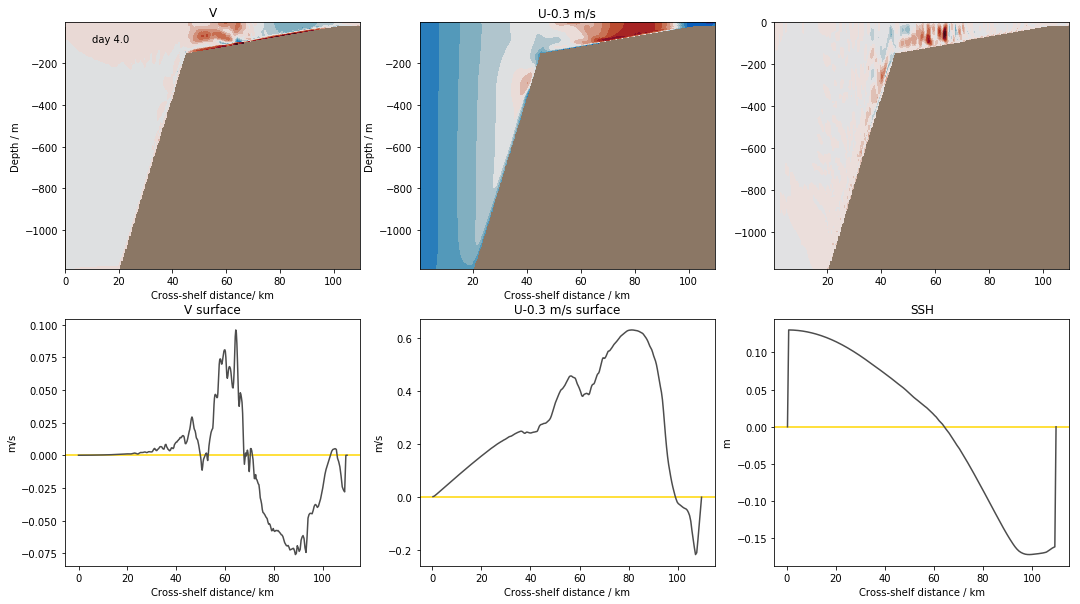

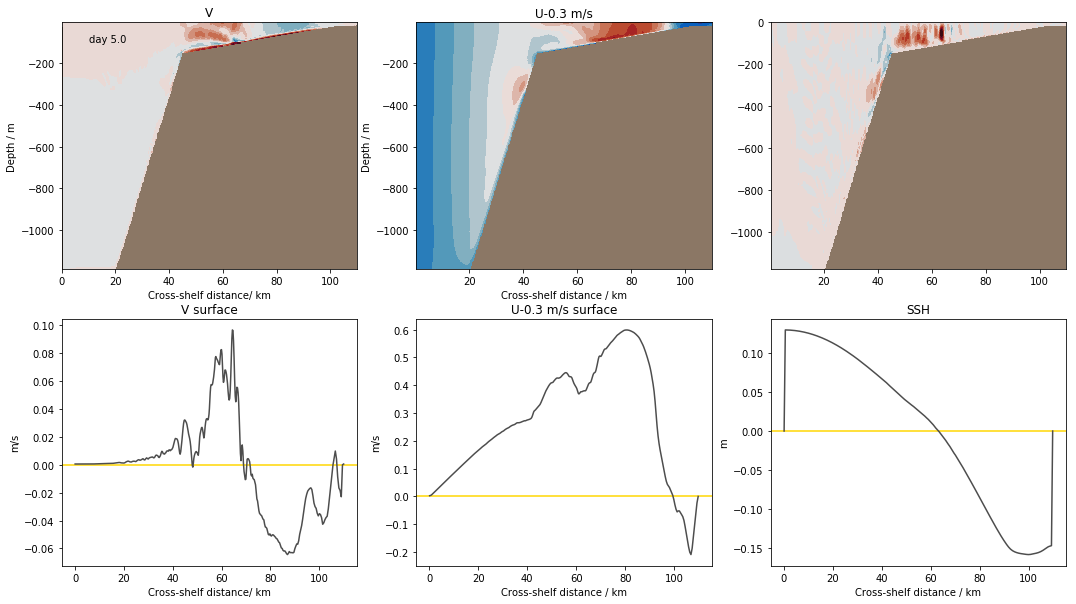

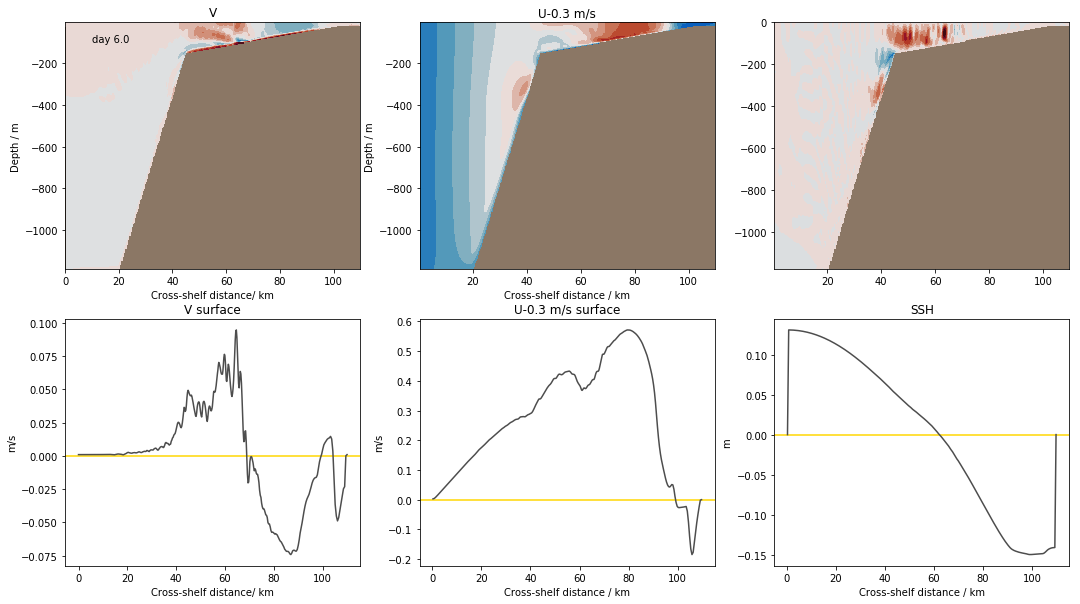

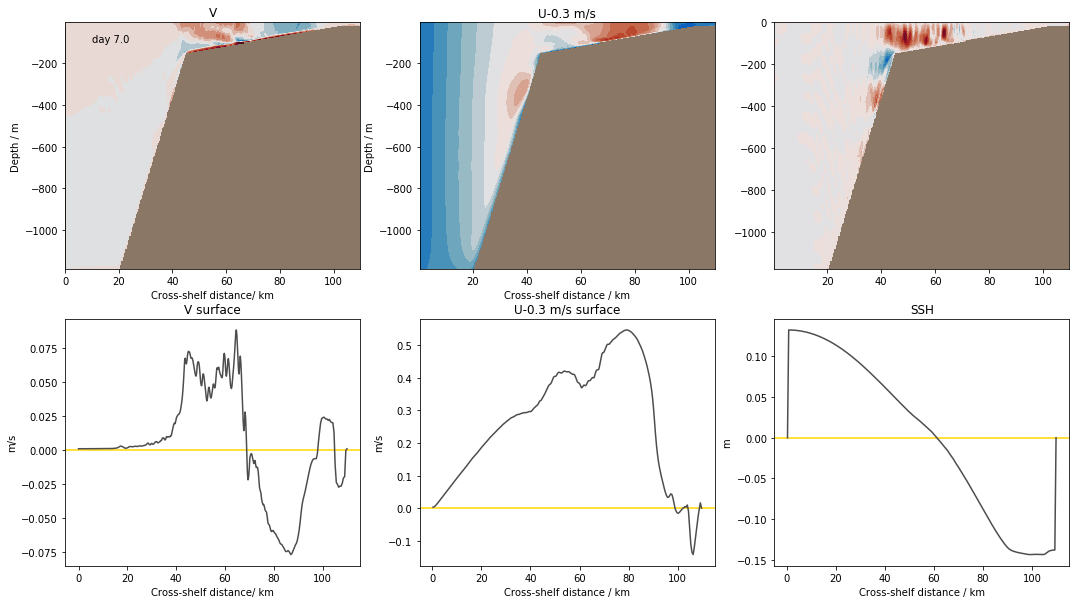

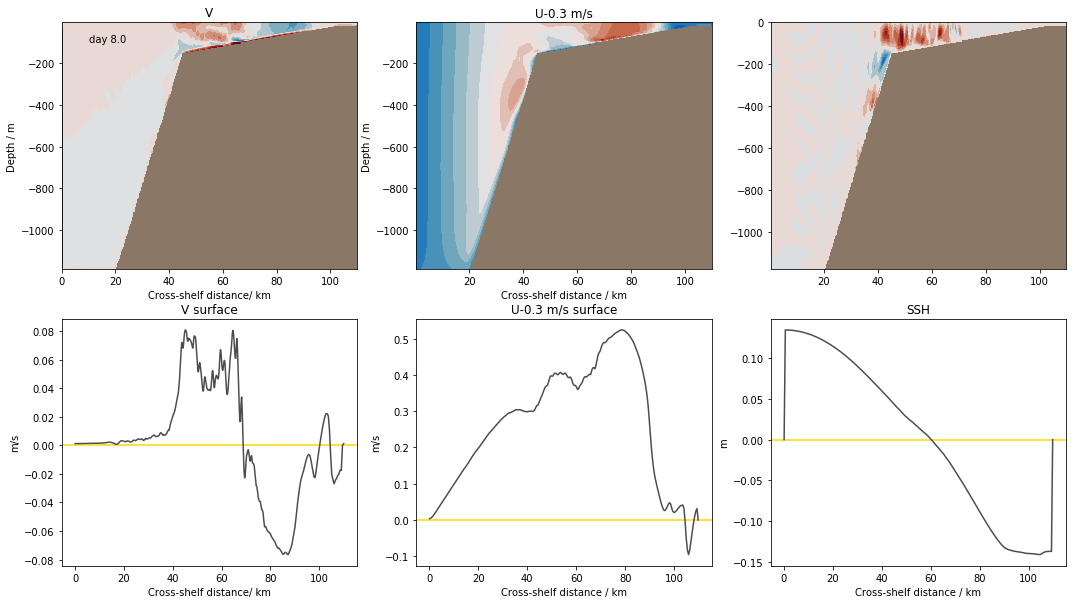

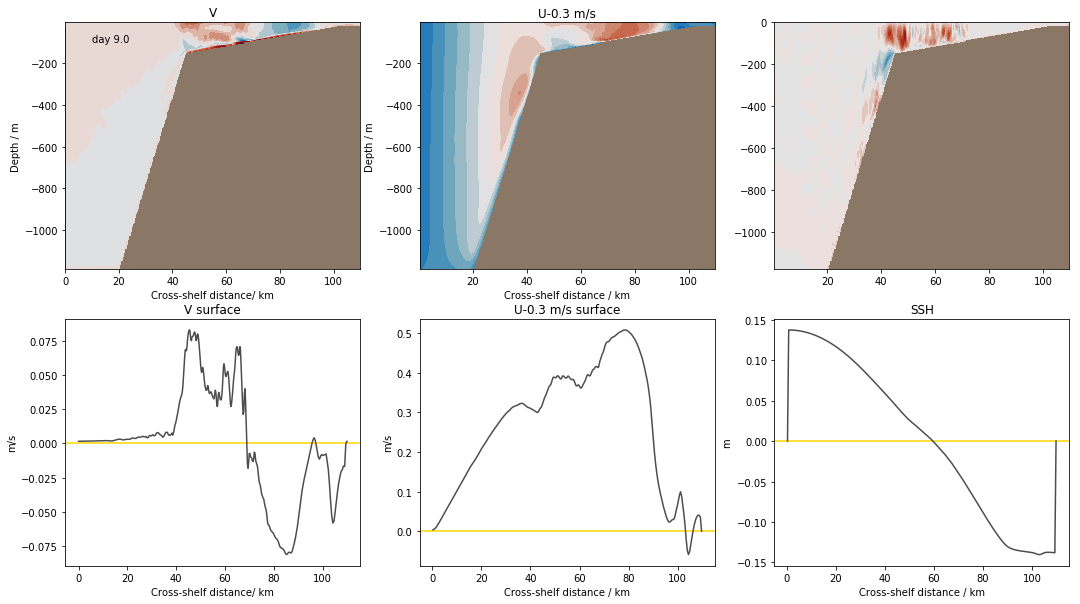

In [12]:
times = np.arange(0,len(state['T']),2)
xind = 260
print('Cross-sections at x=%1.2f km (downstream side)' %(X[xind]/1000))

for t0 in times:
    start = t0
    end = t0+1

    Vmean = np.ma.masked_array(np.mean(state['V'][start:end,:,:,:], axis=0), mask = maskS)
    Umean = np.ma.masked_array(np.mean(state['U'][start:end,:,:,:], axis=0), mask = maskW)
    Wmean = np.ma.masked_array(np.mean(state['W'][start:end,:,:,:], axis=0), mask = maskC)
    SSHmean = np.mean(state['Eta'][start:end,:,:], axis=0)


    plot_CS_wave(Vmean, Umean, Wmean,SSHmean, start, xind=xind, umean=0.3)
    

Cross-sections at x=45.82 km (upstream side)


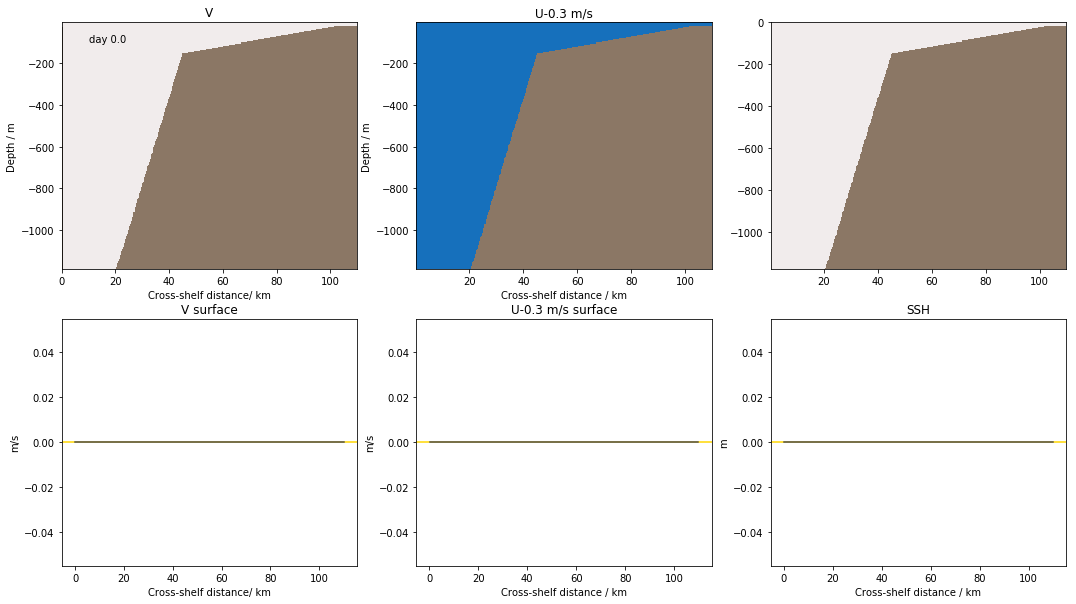

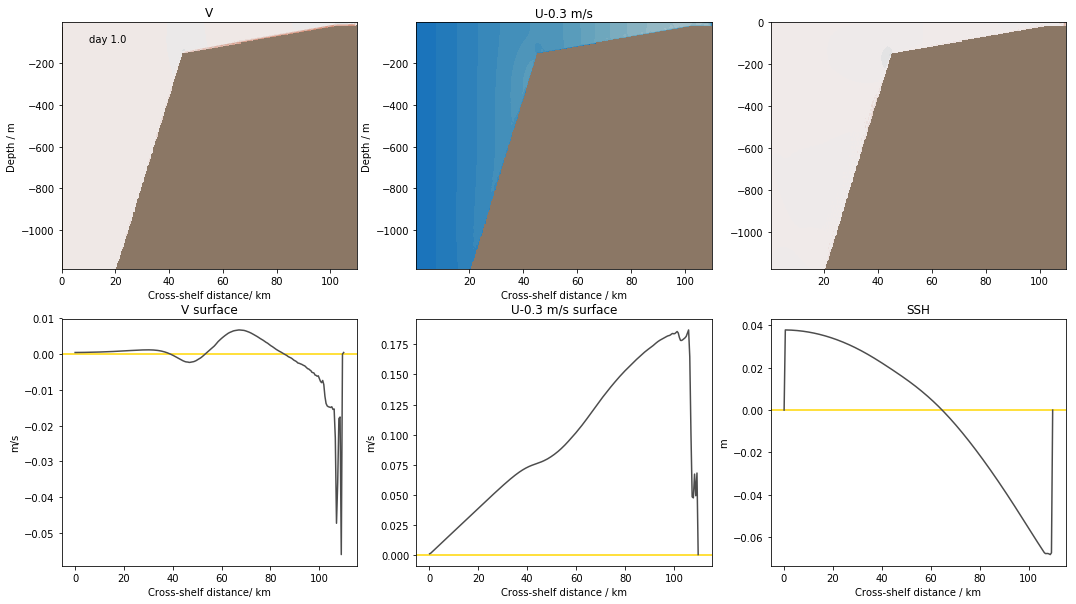

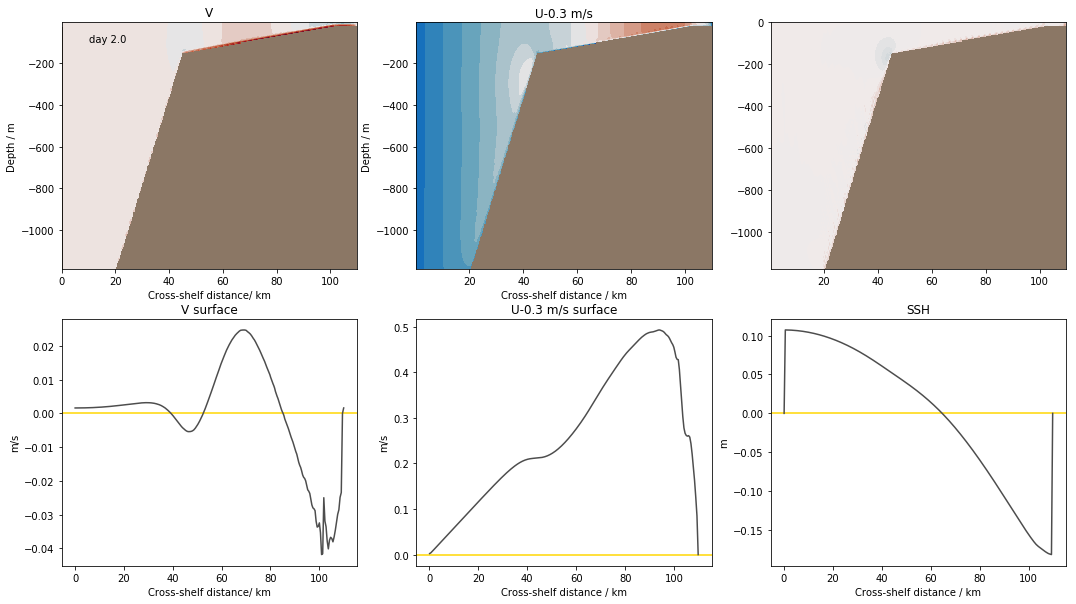

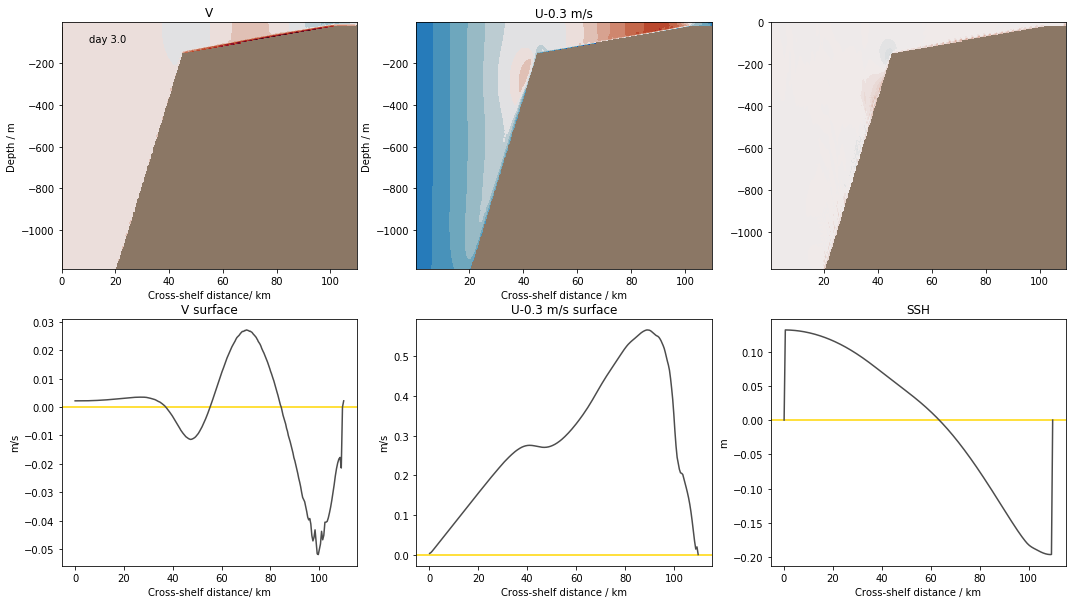

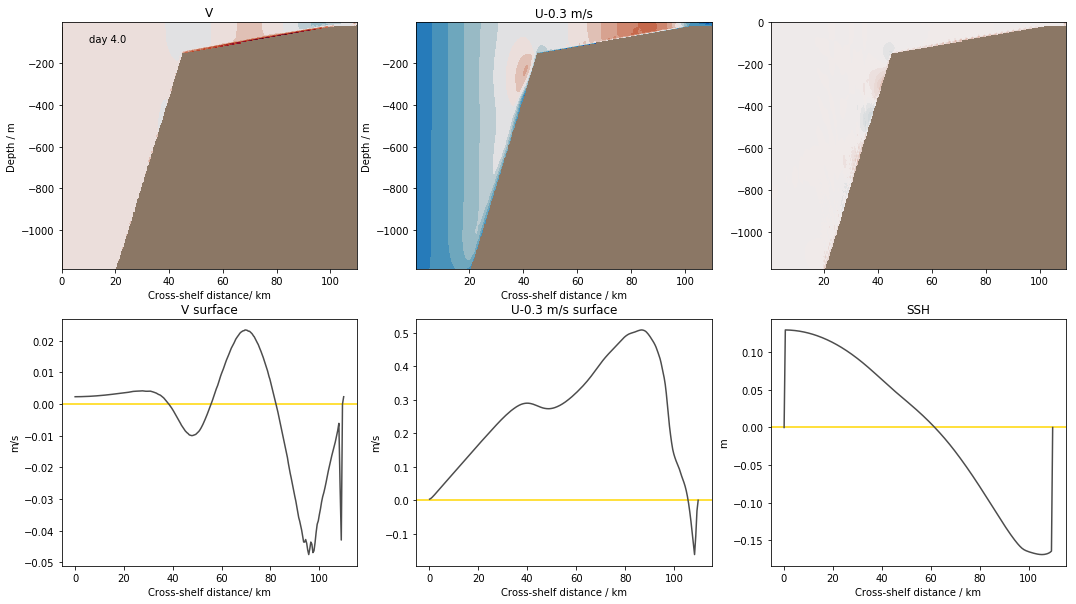

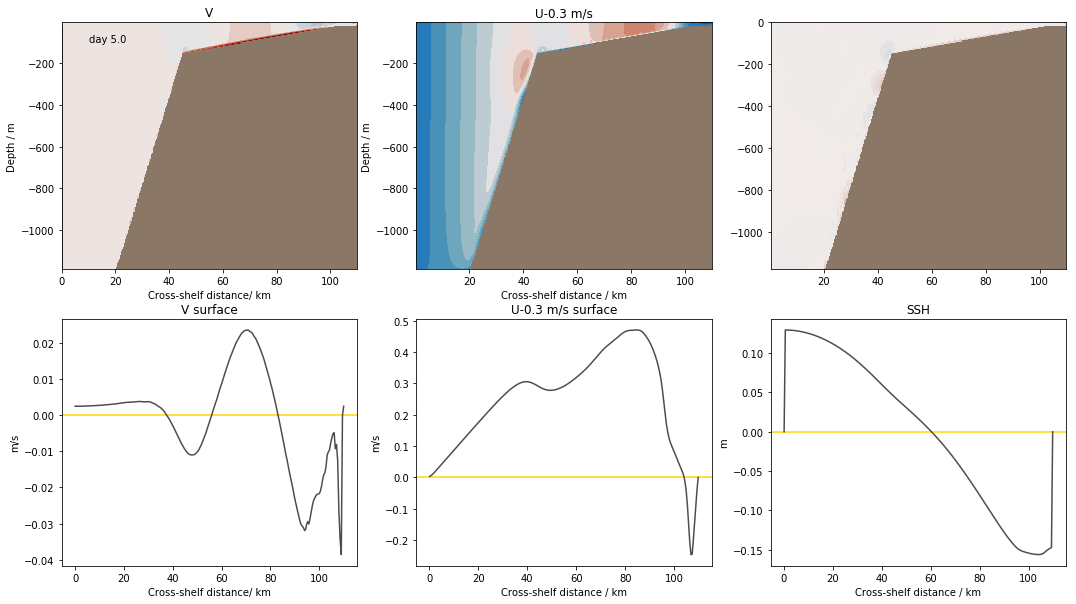

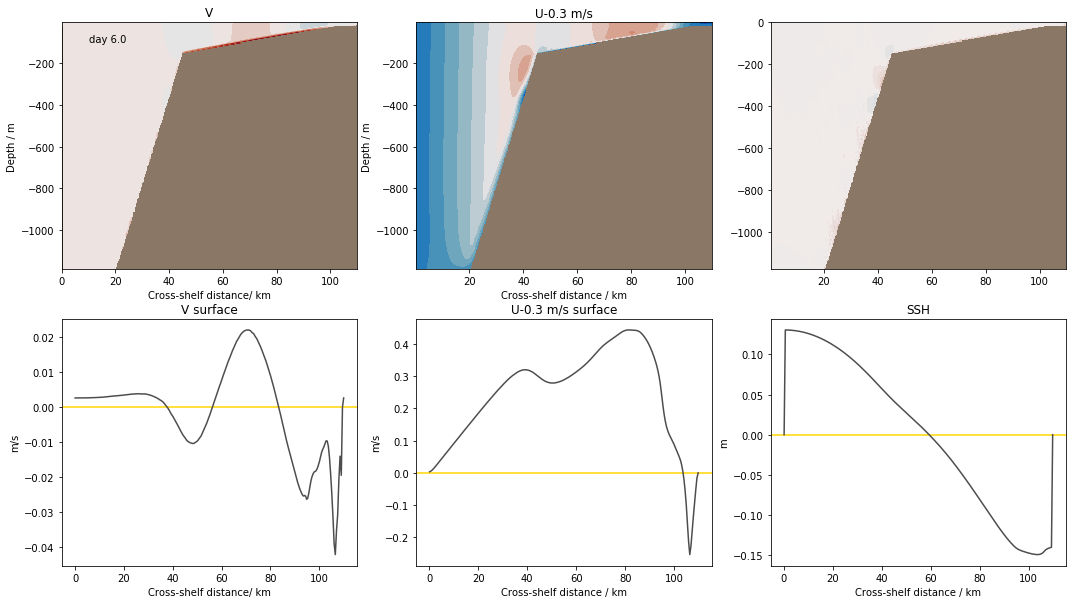

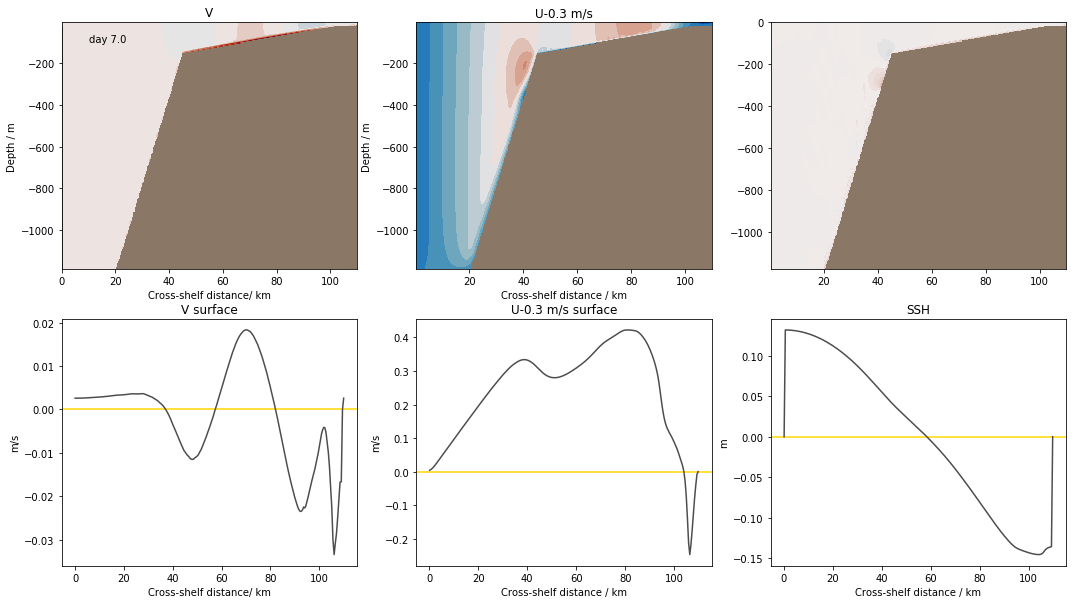

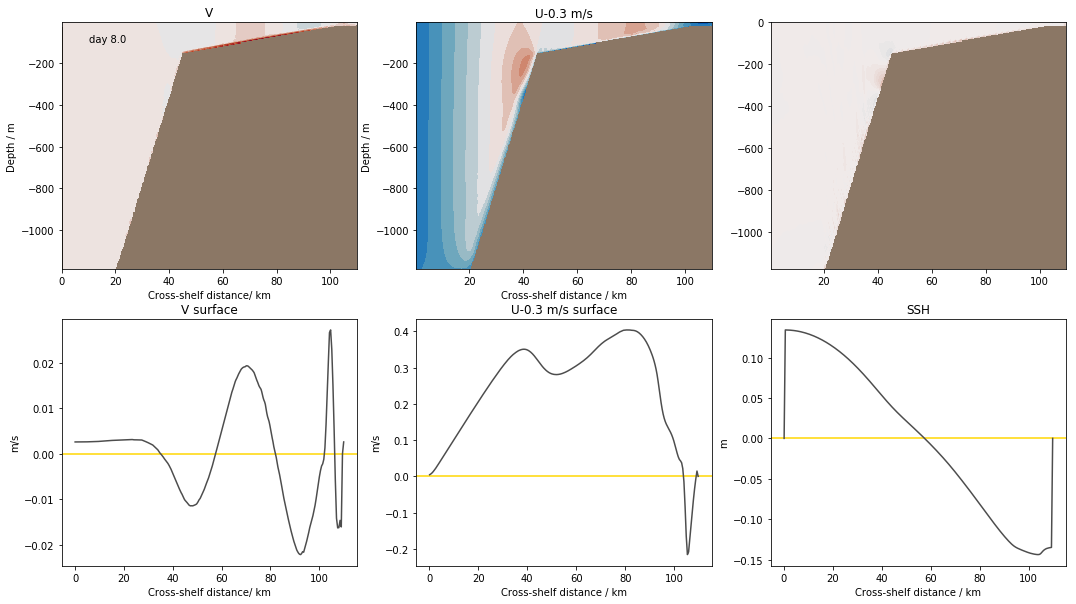

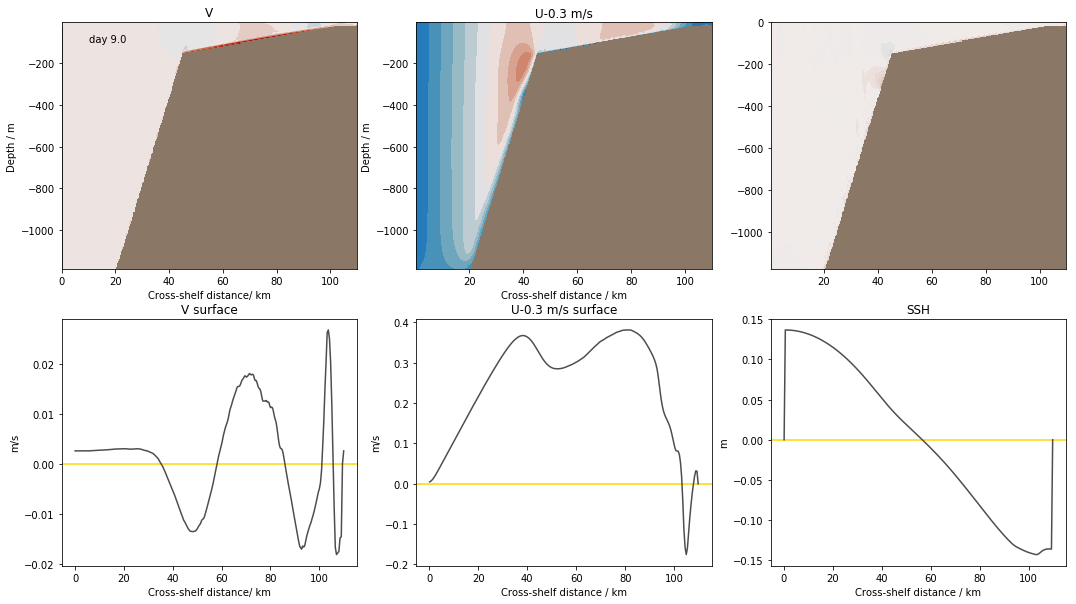

In [16]:
times = np.arange(0,len(state['T']),2)
xind = 100
print('Cross-sections at x=%1.2f km (upstream side)' %(X[xind]/1000))

for t0 in times:
    start = t0
    end = t0+1

    Vmean = np.ma.masked_array(np.mean(state['V'][start:end,:,:,:], axis=0), mask = maskS)
    Umean = np.ma.masked_array(np.mean(state['U'][start:end,:,:,:], axis=0), mask = maskW)
    Wmean = np.ma.masked_array(np.mean(state['W'][start:end,:,:,:], axis=0), mask = maskC)
    SSHmean = np.mean(state['Eta'][start:end,:,:], axis=0)


    plot_CS_wave(Vmean, Umean, Wmean,SSHmean, start, xind=xind, umean=0.3)
   

ratio for wave 0.9365594387539024


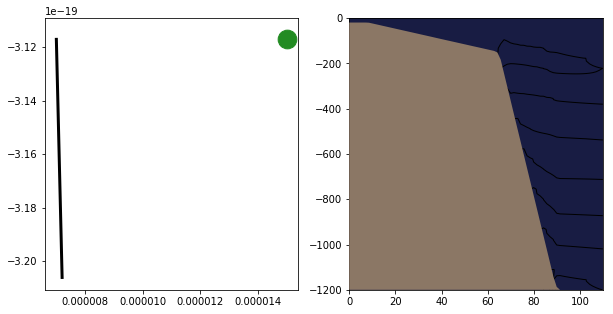

In [55]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

# dispersion curve
output = np.loadtxt('/ocean/kramosmu/CTW_Brink/matlab_files_bigrtemp_IAM/dispc.dat')
disp_k = output[:, 0] #rad/cm
disp_f = output[:, 1] #rad/sec

# Brink mode
file = sio.loadmat('/ocean/kramosmu/CTW_Brink/matlab_files_bigrtemp_IAM/figures.mat')
z, xpl, xxx, zzz = file['z'][0,:], file['xpl'][0,:], file['xxx'][0,:], file['zzz'][0,:]
k, f = file['wavenumber'][0][0], file['frequency'][0][0]

# (u is cross-shore and v is alongshore in Brink. so, I'm flipping them back right here)
p0, v0, u0, w0, r0 = file['p_profile'], file['u_profile'], file['v_profile'], file['w_profile'], file['r_profile']

file_rfw = sio.loadmat('/ocean/kramosmu/CTW_Brink/matlab_files_bigrtemp_IAM/ratio_for_wave.mat')
R = file_rfw['ratio_for_wave'][0][0]
print('ratio for wave', R)

scale=0.2
w = w0 * 0.01 * scale # cms-1 to ms-1 and normalization
u = u0 * 0.01 * scale # cms-1 to ms-1 and normalization 
v = v0 * 0.01 * scale # cms-1 to ms-1 and normalization 
r = r0 * 1.0 * scale # mg/cm³ to kg/m³ and normalization
p = p0 * 0.1 * scale # dyn/cm² to 0.1 Pa (or kg m-1 s-2) and normalization

ax1.plot(disp_k, disp_f, c='k', lw=3, zorder=1)
ax1.scatter(k, f, s=350, c='forestgreen', zorder=2, marker='o')

landc='#8b7765'
levels=np.linspace(np.min(v),np.max(v),10)
p3 = ax2.contourf(xpl, z, v, levels=levels, cmap=cmo.cm.balance, vmin=-np.max(v), vmax=np.max(v), zorder=1)
ax2.contour(xpl, z, v, levels=[0], linewidths=1, linestyles='-', colors='k', zorder=2)
ax2.fill_between(xxx, zzz.min(), zzz, facecolor=landc, zorder=3)

